In [2]:
!pip install tensorflow==2.12.0
!pip install keras==2.12.0

In [2]:
import numpy as np
import os
import imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())

#experiment with the batch size
batch_size = 64
num_classes = 5

print(f'Train length: {len(train_doc)}')
print(f'Validation length: {len(val_doc)}')

Train length: 663
Validation length: 100


**Generator**

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
def preprocess_image(image, channel, height, width):
    image = resize_image(image, height, width)
    return normalise_image(image, channel)

In [8]:
def normalise_image(image, channel):
    return (image[...,channel])/255

In [9]:
def resize_image(image, height, width):
    h, w, c = image.shape
    return resize(image, (height, width), anti_aliasing=True)

In [10]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

In [11]:
def generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height=120, width=120, augment=False):
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


            # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
            if augment:
                image = resize_image(image, height, width)
                if np.random.randn() > 0:
                    image = datagen.random_transform(image)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes

            batch_data[folder,idx,:,:,0] = preprocess_image(image, 0, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = preprocess_image(image, 1, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = preprocess_image(image, 2, height, width) #normalise and feed in the image

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    return batch_data, batch_labels

In [12]:
# Kept default height and width to 120x120
def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

            yield generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height, width)

        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output

            yield generate_common(t, source_path, remaining_batch_size, img_idx, num_batches, batch_data, batch_labels, height, width)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Validating the Generator

In [14]:
# check complete batch shape
sample_generator = generate(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)



(64, 20, 120, 120, 3)


In [15]:
# validation batch sample
sample_val_generator = generate(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

(64, 20, 120, 120, 3)


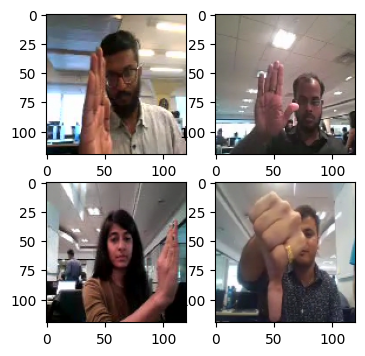

In [17]:
fig, ax = plt.subplots(2,2, figsize=(4,4))
ax[0,0].imshow(sample_batch_data[16,10,:,:,:])
ax[0,1].imshow(sample_batch_data[25,10,:,:,:])

ax[1,0].imshow(sample_val_batch_data[16,10,:,:,:])
ax[1,1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

# **Model**

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import  Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [17]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())

    # fig, ax = plt.subplots(1,2, figsize=(16,8))

    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [18]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

In [19]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [20]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

### **Model 1:**
Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [23]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 60  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 60
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [24]:
callbacks_list = model_callbacks("model_30_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    workers=1,
                    initial_epoch=0)

Epoch 1/20
 8/12 [===================>..........] - ETA: 15:32 - loss: 1.6517 - categorical_accuracy: 0.4271

In [ ]:
plot_loss_accuracy(history)

Model 2:
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [21]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activatio

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
callbacks_list = model_callbacks("model_20_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5577 - categorical_accuracy: 0.4480 
Epoch 1: val_loss improved from inf to 1.84006, saving model to model_20_conv3D_2_2024-12-1022_42_08.175576/model-00001-1.55771-0.44796-1.84006-0.40000.h5
67/67 [==============================] - 1998s 30s/step - loss: 1.5577 - categorical_accuracy: 0.4480 - val_loss: 1.8401 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/20
46/67 [===================>..........] - ETA: 6:31 - loss: 1.0673 - categorical_accuracy: 0.5652

In [ ]:
plot_loss_accuracy(history)

## **Model 3:**

Conv 3D Model with 30 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_30_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

## **Model 4:**

Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_20_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

## **TRANSFER LEARNING - MobileNet Conv2d + GRU**

In [ ]:
from keras.applications import mobilenet

def mobilenet_RNN_GRU_LSTM((fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(keras.layers.MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## **Model 5:**
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=True, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_20_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

### **Model 6:**

Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=True, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

## **Model 7:**

Mobilenet 20 frames (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=False, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_20_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


In [ ]:
plot_loss_accuracy(history)

## **Model 8:**

Mobilenet 30 frames (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=False, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

## Load Selected Model

Loading the selected model from the disk

In [ ]:
# /content/model_30_conv3D_1_2024-12-1020_25_03.161033

from keras.models import load_model
model = load_model('model-00016-0.03003-0.99548-0.05517-0.98000.h5')
model.summary()